https://towardsdatascience.com/how-to-build-a-movie-recommendation-system-67e321339109

IMPORT AND SET UP DATASET

In [1]:
import pandas as pd
data = pd.read_csv("ratings.csv")
data


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [2]:
data = data.drop('timestamp',axis=1)
data

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [3]:
trainData=data.iloc[:int(data.shape[0]*0.80)]
testData=data.iloc[int(data.shape[0]*0.80):]

print(trainData.shape)
testData.shape

(80668, 3)


(20168, 3)

In [4]:
from surprise import SVD
import numpy as np
import surprise
from surprise import Reader, Dataset

reader = Reader(rating_scale=(1,5))
# Convert data to appropriate format
mfTrain = Dataset.load_from_df(trainData[['userId', 'movieId', 'rating']], reader)
trainset = mfTrain.build_full_trainset()

In [5]:
reader = Reader(rating_scale=(1,5))
mfTest = Dataset.load_from_df(testData[['userId', 'movieId', 'rating']], reader)
testset = mfTest.build_full_trainset()

In [6]:
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [7]:
#getting predictions of trainset
train_preds = svd.test(trainset.build_testset())

mfTrain = np.array([pred.est for pred in train_preds])

#getting predictions of trainset
test_preds = svd.test(testset.build_testset())
mfTest = np.array([pred.est for pred in test_preds])

XGBoost

In [8]:
from scipy import sparse
# Creating a sparse matrix
train_sparse_matrix = sparse.csr_matrix((trainData.rating.values, (trainData.userId.values,
                                               trainData.movieId.values)))

In [9]:
# Global avg of all movies by all users

train_averages = dict()
# get the global average of ratings in our train set.
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
train_averages

{'global': 3.5199769425298757}

In [10]:
# get the user averages in dictionary (key: user_id/movie_id, value: avg rating)

def get_average_ratings(sparse_matrix, of_users):
    
    # average ratings of user/axes
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    # no of ratings that each user OR movie..
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # max_user  and max_movie ids in sparse matrix 
    u,m = sparse_matrix.shape
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    # return that dictionary of average ratings
    return average_ratings

In [11]:
#Average rating given by a user

train_averages['user'] = get_average_ratings(train_sparse_matrix, of_users=True)
print('\nAverage rating of user 10 :',train_averages['user'][10])


Average rating of user 10 : 3.2785714285714285


In [12]:
#Average rating for a movie


train_averages['movie'] =  get_average_ratings(train_sparse_matrix, of_users=False)
print('\n Average rating of movie 15 :',train_averages['movie'][15])


 Average rating of movie 15 : 3.0


In [13]:
# get users, movies and ratings from our samples train sparse matrix

train_users, train_movies, train_ratings = sparse.find(train_sparse_matrix)

In [14]:
import time
from sklearn.metrics.pairwise import cosine_similarity

finalTrainData = pd.DataFrame()
count = 0
start = time.time()
for (user, movie, rating)  in zip(train_users, train_movies, train_ratings):
            #st = datetime.now()
            #print(user, movie)    
            #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            # compute the similar Users of the "user"        
            user_sim = cosine_similarity(train_sparse_matrix[user], train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar users for this movie
            top_ratings = train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            # we will make it's length "5" by adding movie averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
            #print(top_sim_users_ratings, end=" ")    


            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            # compute the similar movies of the "movie"        
            movie_sim = cosine_similarity(train_sparse_matrix[:,movie].T, train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar movie rated by this user..
            top_ratings = train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
            #print(top_sim_movies_ratings, end=" : -- ")

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(train_averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(train_averages['user'][user])
            # Avg_movie rating
            row.append(train_averages['movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1
            finalTrainData = finalTrainData.append([row])

           
        
            if (count)%1000 == 0:
                # print(','.join(map(str, row)))
                #print(user, movie)
                #print(top_sim_users_ratings)
                #print(top_sim_movies_ratings)
                print("Done for {} rows----- {}".format(count, time.time() - start))

Done for 1000 rows----- 29.19899320602417
Done for 2000 rows----- 57.03638672828674
Done for 3000 rows----- 84.26538562774658
Done for 4000 rows----- 111.64038896560669
Done for 5000 rows----- 138.94960141181946
Done for 6000 rows----- 165.74846935272217
Done for 7000 rows----- 192.85444021224976
Done for 8000 rows----- 221.24947023391724
Done for 9000 rows----- 249.23348474502563
Done for 10000 rows----- 276.73644518852234
Done for 11000 rows----- 304.3524477481842
Done for 12000 rows----- 331.87944412231445
Done for 13000 rows----- 359.6985273361206
Done for 14000 rows----- 388.0354018211365
Done for 15000 rows----- 416.26144075393677
Done for 16000 rows----- 445.7543125152588
Done for 17000 rows----- 474.1407332420349
Done for 18000 rows----- 502.31730103492737
Done for 19000 rows----- 530.8832578659058
Done for 20000 rows----- 559.4933023452759
Done for 21000 rows----- 588.673259973526
Done for 22000 rows----- 618.101410150528
Done for 23000 rows----- 646.7804110050201
Done for 240

In [15]:
finalTrainData.columns=['user', 'movie', 'GAvg', 'simU1', 'simU2', 'simU3', 'simU4', 'simU5',
            'SimM1', 'SimM2', 'SimM3', 'SimM4', 'SimM5', 'UserAvg', 'MovAvg', 'rating']

In [16]:
print(finalTrainData.shape)
print(finalTrainData.head())

(80668, 16)
   user  movie      GAvg  simU1  simU2  simU3  simU4  simU5  SimM1  SimM2  \
0     1      1  3.519977    2.0    5.0    4.0    4.0    4.5    3.0    4.0   
0     5      1  3.519977    4.0    5.0    4.0    4.0    5.0    4.0    3.0   
0     7      1  3.519977    4.0    4.0    5.0    4.5    4.0    4.5    4.5   
0    15      1  3.519977    5.0    3.0    4.0    4.0    4.0    3.5    3.0   
0    17      1  3.519977    4.0    5.0    4.0    4.0    4.5    4.0    4.5   

   SimM3  SimM4  SimM5   UserAvg    MovAvg  rating  
0    3.0    5.0    5.0  4.366379  3.954545     4.0  
0    3.0    5.0    5.0  3.636364  3.954545     4.0  
0    5.0    4.0    3.0  3.230263  3.954545     4.5  
0    5.0    3.0    3.0  3.448148  3.954545     2.5  
0    5.0    5.0    5.0  4.209524  3.954545     4.5  


In [17]:
print(mfTrain.shape)
print(finalTrainData.shape)
# add in matrix factorization output
finalTrainData['mf_svd']=mfTrain
finalTrainData.head()

(80668,)
(80668, 16)


,user,movie,GAvg,simU1,simU2,simU3,simU4,simU5,SimM1,SimM2,SimM3,SimM4,SimM5,UserAvg,MovAvg,rating,mf_svd
0,1,1,3.519977,2.0,5.0,4.0,4.0,4.5,3.0,4.0,3.0,5.0,5.0,4.366379,3.954545,4.0,4.306195
0,5,1,3.519977,4.0,5.0,4.0,4.0,5.0,4.0,3.0,3.0,5.0,5.0,3.636364,3.954545,4.0,3.941735
0,7,1,3.519977,4.0,4.0,5.0,4.5,4.0,4.5,4.5,5.0,4.0,3.0,3.230263,3.954545,4.5,4.543556
0,15,1,3.519977,5.0,3.0,4.0,4.0,4.0,3.5,3.0,5.0,3.0,3.0,3.448148,3.954545,2.5,4.677380
0,17,1,3.519977,4.0,5.0,4.0,4.0,4.5,4.0,4.5,5.0,5.0,5.0,4.209524,3.954545,4.5,4.810359


Test Data

In [18]:
# Creating a sparse matrix
test_sparse_matrix = sparse.csr_matrix((testData.rating.values, (testData.userId.values,
                                               testData.movieId.values)))

In [19]:
# Global avg of all movies by all users

test_averages = dict()
# get the global average of ratings in our train set.
test_global_average = test_sparse_matrix.sum()/test_sparse_matrix.count_nonzero()
test_averages['global'] = test_global_average
test_averages

{'global': 3.4278808012693376}

In [20]:
# get the user averages in dictionary (key: user_id/movie_id, value: avg rating)

def get_average_ratings(sparse_matrix, of_users):
    
    # average ratings of user/axes
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    # no of ratings that each user OR movie..
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # max_user  and max_movie ids in sparse matrix 
    u,m = sparse_matrix.shape
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    # return that dictionary of average ratings
    return average_ratings

In [21]:
# Average ratings given by a user

test_averages['user'] = get_average_ratings(test_sparse_matrix, of_users=True)
#print('\nAverage rating of user 10 :',test_averages['user'][10])

# Average ratings given for a movie

test_averages['movie'] =  get_average_ratings(test_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 15 :',test_averages['movie'][15])


 AVerage rating of movie 15 : 3.0


In [22]:
# get users, movies and ratings from our samples train sparse matrix
test_users, test_movies, test_ratings = sparse.find(test_sparse_matrix)

In [23]:
import time
from sklearn.metrics.pairwise import cosine_similarity

start = time.time()
finalTest = pd.DataFrame()
count = 0
for (user, movie, rating)  in zip(test_users, test_movies, test_ratings):
            #st = datetime.now()
        #     print(user, movie)    
            #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            # compute the similar Users of the "user"        
            user_sim = cosine_similarity(test_sparse_matrix[user], test_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar users for this movie
            top_ratings = test_sparse_matrix[top_sim_users, movie].toarray().ravel()
            # we will make it's length "5" by adding movie averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([test_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
        #     print(top_sim_users_ratings, end=" ")    


            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            # compute the similar movies of the "movie"        
            movie_sim = cosine_similarity(test_sparse_matrix[:,movie].T, test_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar movie rated by this user..
            top_ratings = test_sparse_matrix[user, top_sim_movies].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([test_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
        #     print(top_sim_movies_ratings, end=" : -- ")

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(test_averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(test_averages['user'][user])
            # Avg_movie rating
            row.append(test_averages['movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1
            finalTest = finalTest.append([row])

           
        
            if (count)%1000 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, time.time() - start))

Done for 1000 rows----- 28.505134105682373
Done for 2000 rows----- 57.785176038742065
Done for 3000 rows----- 87.21038150787354
Done for 4000 rows----- 115.79640173912048
Done for 5000 rows----- 148.59022188186646
Done for 6000 rows----- 182.36217713356018
Done for 7000 rows----- 214.2662844657898
Done for 8000 rows----- 242.9872772693634
Done for 9000 rows----- 271.9112675189972
Done for 10000 rows----- 301.40921568870544
Done for 11000 rows----- 330.4119873046875
Done for 12000 rows----- 361.47194957733154
Done for 13000 rows----- 392.786408662796
Done for 14000 rows----- 423.1756694316864
Done for 15000 rows----- 453.3213007450104
Done for 16000 rows----- 483.8224949836731
Done for 17000 rows----- 513.6631207466125
Done for 18000 rows----- 546.5057654380798
Done for 19000 rows----- 576.6303038597107
Done for 20000 rows----- 606.8621909618378


In [24]:
print(finalTest.shape)
print(finalTest.columns)
finalTest.columns=['user', 'movie', 'GAvg', 'simU1', 'simU2', 'simU3', 'simU4', 'simU5',
            'SimM1', 'SimM2', 'SimM3', 'SimM4', 'SimM5', 'UserAvg', 'MovAvg', 'rating']

(20168, 16)
RangeIndex(start=0, stop=16, step=1)


In [25]:
# add in the matrix factorization output

finalTest['mf_svd']=mfTest
finalTest

,user,movie,GAvg,simU1,simU2,simU3,simU4,simU5,SimM1,SimM2,SimM3,SimM4,SimM5,UserAvg,MovAvg,rating,mf_svd
0,514,1,3.427881,4.0,4.00,4.00,4.00,4.00,4.0,4.0,4.0,2.5,5.0,3.311083,3.769231,4.0,3.425865
0,517,1,3.427881,4.0,4.00,4.00,2.50,4.00,3.5,2.0,3.0,3.5,5.0,2.386250,3.769231,4.0,3.229036
0,522,1,3.427881,5.0,4.00,4.00,4.00,3.00,3.5,4.0,5.0,5.0,5.0,3.830000,3.769231,3.0,3.026007
0,524,1,3.427881,5.0,4.00,5.00,3.00,4.00,3.0,3.0,3.0,5.0,5.0,3.458015,3.769231,4.0,3.004834
0,525,1,3.427881,4.0,3.00,5.00,2.50,4.00,4.0,4.0,4.0,4.5,4.0,3.542000,3.769231,4.0,2.366412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,586,187593,3.427881,3.5,3.75,3.75,3.75,3.75,5.0,3.5,3.5,4.0,5.0,4.365385,3.750000,4.0,3.450431
0,514,187595,3.427881,5.0,4.00,4.00,4.00,4.00,3.5,2.0,4.0,2.0,3.0,3.311083,4.000000,3.0,3.784835
0,586,187595,3.427881,3.0,4.00,4.00,4.00,4.00,4.0,4.5,4.0,4.0,4.0,4.365385,4.000000,5.0,3.561571
0,596,188301,3.427881,4.0,4.00,4.00,4.00,4.00,4.0,4.5,2.5,4.0,4.0,3.495134,4.000000,4.0,3.921782


XGBoost creation

In [26]:
from sklearn.metrics import mean_absolute_error

def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

In [27]:
# prepare train data
x_train = finalTrainData.drop(['user', 'movie','rating'], axis=1)
y_train = finalTrainData['rating']

In [28]:
# Prepare Test data
x_test = finalTest.drop(['user','movie','rating'], axis=1)
y_test = finalTest['rating']

In [29]:
import xgboost as xgb
import time
# initialize XGBoost model...
xgb_model = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
# dictionaries for storing train and test results
train_results = dict()
test_results = dict()
    
    
# fit the model
print('Training the model..')
start =time.time()
xgb_model.fit(x_train, y_train, eval_metric = 'rmse')
print('Done. Time taken : {}\n'.format(time.time()-start))
print('Done \n')

Training the model..
[17:55:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Done. Time taken : 8.737995386123657

Done 



In [30]:
# from the trained model, get the predictions....
print('Evaluating the model with TRAIN data...')
start =time.time()
y_train_pred = xgb_model.predict(x_train)
# get the rmse and mape of train data...
rmse_train, mape_train, mae_train = get_error_metrics(y_train.values, y_train_pred)
    
# store the results in train_results dictionary..
train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'mae'  : mae_train,
                    'predictions' : y_train_pred}

Evaluating the model with TRAIN data...


C:\Users\srira\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [31]:
train_results

{'rmse': 0.6781111999765105,
 'mape': 20.54832458104446,
 'mae': 0.5117222712224767,
 'predictions': array([4.1716933, 3.9454303, 3.8573043, ..., 3.7118096, 3.7118096,
        4.1530914], dtype=float32)}

In [32]:
from sklearn.metrics import mean_absolute_error
from xgboost import cv
#######################################
# get the test data predictions and compute rmse and mape
print('Evaluating Test data')



y_test_pred = xgb_model.predict(x_test) 
rmse_test, mape_test, mae_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
# store them in our test results dictionary.
test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'mae'  : mae_test,
                    'predictions':y_test_pred}


Evaluating Test data


C:\Users\srira\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [33]:
#cross validation

from sklearn.model_selection import cross_val_score

XGB_accuracies = cross_val_score(estimator = xgb_model, X = x_test, y = y_test, cv = 10, scoring='neg_mean_absolute_error')

[17:55:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\srira\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:55:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\srira\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:55:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\srira\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:55:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\srira\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:55:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\srira\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:55:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\srira\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:55:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\srira\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:55:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\srira\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:55:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\srira\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:55:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\srira\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [34]:
print(test_results)

{'rmse': 0.6727881263237749, 'mape': 19.868316728441393, 'mae': 0.49673443565659375, 'predictions': array([3.752498 , 3.0354886, 4.247462 , ..., 4.5327907, 4.1087923,
       3.2920923], dtype=float32)}


In [35]:
maes = []
for i in range(0, len(XGB_accuracies)):
    maes.append(-1 * XGB_accuracies[i])
print(maes)

[0.5815836663256794, 0.5609908832378416, 0.517905572867949, 0.4844918411648031, 0.505054748318369, 0.43121105125178544, 0.3769662363004968, 0.3450739507812288, 0.3481517477212326, 0.31360993957302224]


In [36]:
pragnaMAE = [0.69, 0.65, 0.73, 0.72, 0.69, 0.65, 0.73, 0.69, 0.69, 0.72]
print(pragnaMAE)

pragMSE = [0.92, 0.95, 0.88, 0.92, 0.92, 0.875, 0.895, 0.95, 0.955, 0.92]
pragnaRMSE = []

for elem in pragMSE:
    pragnaRMSE.append(elem ** 0.5)
print(pragnaRMSE)

conorRMSE = [0.8722 , 0.8685 , 0.8599 , 0.8659 , 0.8642 , 0.8703 , 0.8723 , 0.8622 , 0.8711 , 0.8810]
conorMAE = [0.6638 , 0.6652 , 0.6658,  0.6654 , 0.6759 , 0.6671 , 0.6562  ,0.6659  ,0.6741 , 0.6686 ]

allMAE = []
allMAE.append(maes)
allMAE.append(pragnaMAE)
allMAE.append(conorMAE)

allRMSE = []

allRMSE.append(maes)
allRMSE.append(pragnaRMSE)
allRMSE.append(conorRMSE)

print(allMAE)

[0.69, 0.65, 0.73, 0.72, 0.69, 0.65, 0.73, 0.69, 0.69, 0.72]
[0.9591663046625439, 0.9746794344808963, 0.938083151964686, 0.9591663046625439, 0.9591663046625439, 0.9354143466934853, 0.9460443964212251, 0.9746794344808963, 0.9772410142846032, 0.9591663046625439]
[[0.5815836663256794, 0.5609908832378416, 0.517905572867949, 0.4844918411648031, 0.505054748318369, 0.43121105125178544, 0.3769662363004968, 0.3450739507812288, 0.3481517477212326, 0.31360993957302224], [0.69, 0.65, 0.73, 0.72, 0.69, 0.65, 0.73, 0.69, 0.69, 0.72], [0.6638, 0.6652, 0.6658, 0.6654, 0.6759, 0.6671, 0.6562, 0.6659, 0.6741, 0.6686]]


Text(0.5, 1.0, 'Mean Absolute Error after running 10-fold cross validation')

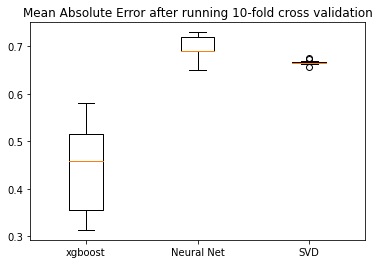

In [37]:
import matplotlib.pyplot as plt

plt.boxplot(allMAE, labels=['xgboost', 'Neural Net', 'SVD'])
plt.title("Mean Absolute Error after running 10-fold cross validation")

In [38]:
#del x_test["Predicted Rating"]
#del y_test["Predicted Rating"]

#print(x_test)
#print(y_test)